Импортируем необходимые библиотеки. 

Для работы с данными используются библиотеки NumPy и Pandas.

Для визуализации используются библиотеки matplotlib и seaborn.

В качестве модели используется XGBRegressor, параметры которого были подобраны с помощью библиотеки optuna.

Для оценки качества модели используются метрики из библиотеки scikit-learn.

In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# **1. Чтение данных**

Исходные данные представлены в виде таблицы признаков в формате csv. Для чтения используем Pandas

In [3]:
data = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv').reset_index(drop=True)
X_test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv').set_index('id')
submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv').set_index('id')

# **2. Вспомогательные методы**

Для более информативного представления таблиц датафреймов определим вспомогательный метод, устанавливающий стиль для таблиц.
Также определим методы для добавление двух новых признаков и отбрасывании ненужных столбцов.

In [12]:
def set_frame_style(df, caption=''):
    """
    Helper function to set datafram presentation style
    """
    return df.style.background_gradient(cmap='PuBuGn').set_caption(caption).set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'dark'),
            ('font-size', '18px'),
            ('font-weight', 'bold')
        ]
    }])

def feature_engeenering(df):
    df['children_ratio'] = df['total_children'] / df['num_children_at_home']
    df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf, np.nan], 10)
    
    mean_store_sqft = df['store_sqft'].mean()
    df['store_sqft_florist'] = df['store_sqft'] * df['florist']
    df['store_sqft_quad'] = (df['store_sqft'] - mean_store_sqft) ** 2
    
    return df

def drop_useless_cols(df, cols):
    return df.drop(columns=cols)

# **3. Исследование данных**

In [5]:
display(set_frame_style(data.head(), 'Первые пять строк исходных данных'))
display(set_frame_style(data.describe(), 'Статистика по сырым данным'))
display(set_frame_style(data.nunique().to_frame().rename({0: 'Количество уникальных значений в столбцах'}, axis=1).transpose(), 'Количество уникальных значений в столбцах'))
display(set_frame_style(data.isna().any().to_frame().transpose(), 'Столбцы с NaN-значениями'))

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.610000,3.000000,2.000000,2.000000,2.000000,10.300000,1.000000,0.000000,32.000000,36509.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.090000
1,1,5.000000,2.000000,4.000000,0.000000,3.000000,6.660000,1.000000,0.000000,1.000000,28206.000000,1.000000,0.000000,0.000000,0.000000,0.000000,121.800000
2,2,14.080000,4.000000,0.000000,0.000000,3.000000,21.300000,1.000000,0.000000,26.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,83.510000
3,3,4.020000,3.000000,5.000000,0.000000,0.000000,14.800000,0.000000,1.000000,36.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,66.780000
4,4,2.130000,3.000000,5.000000,0.000000,3.000000,17.000000,1.000000,1.000000,20.000000,27694.000000,1.000000,1.000000,1.000000,1.000000,1.000000,111.510000


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
Количество уникальных значений в столбцах,360336,1044,6,6,6,5,384,2,2,36,20,2,2,2,2,2,328


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**Можно разбить признаки на несколько категорий:**

* **Бинарные признаки: recyclable_package, low_fat, coffee_bar, video_store, salad_bar, prepared_food, florist**
* **Численные признаки (действительные числа): store_sales(in millions), gross_weight, store_sqft, cost**
* **Порядковые признаки: unit_sales(in millions), total_children, num_children_at_home, avg_cars_at home(approx).1, units_per_case**

**Построим матрицу корреляций между признаками**

<AxesSubplot:>

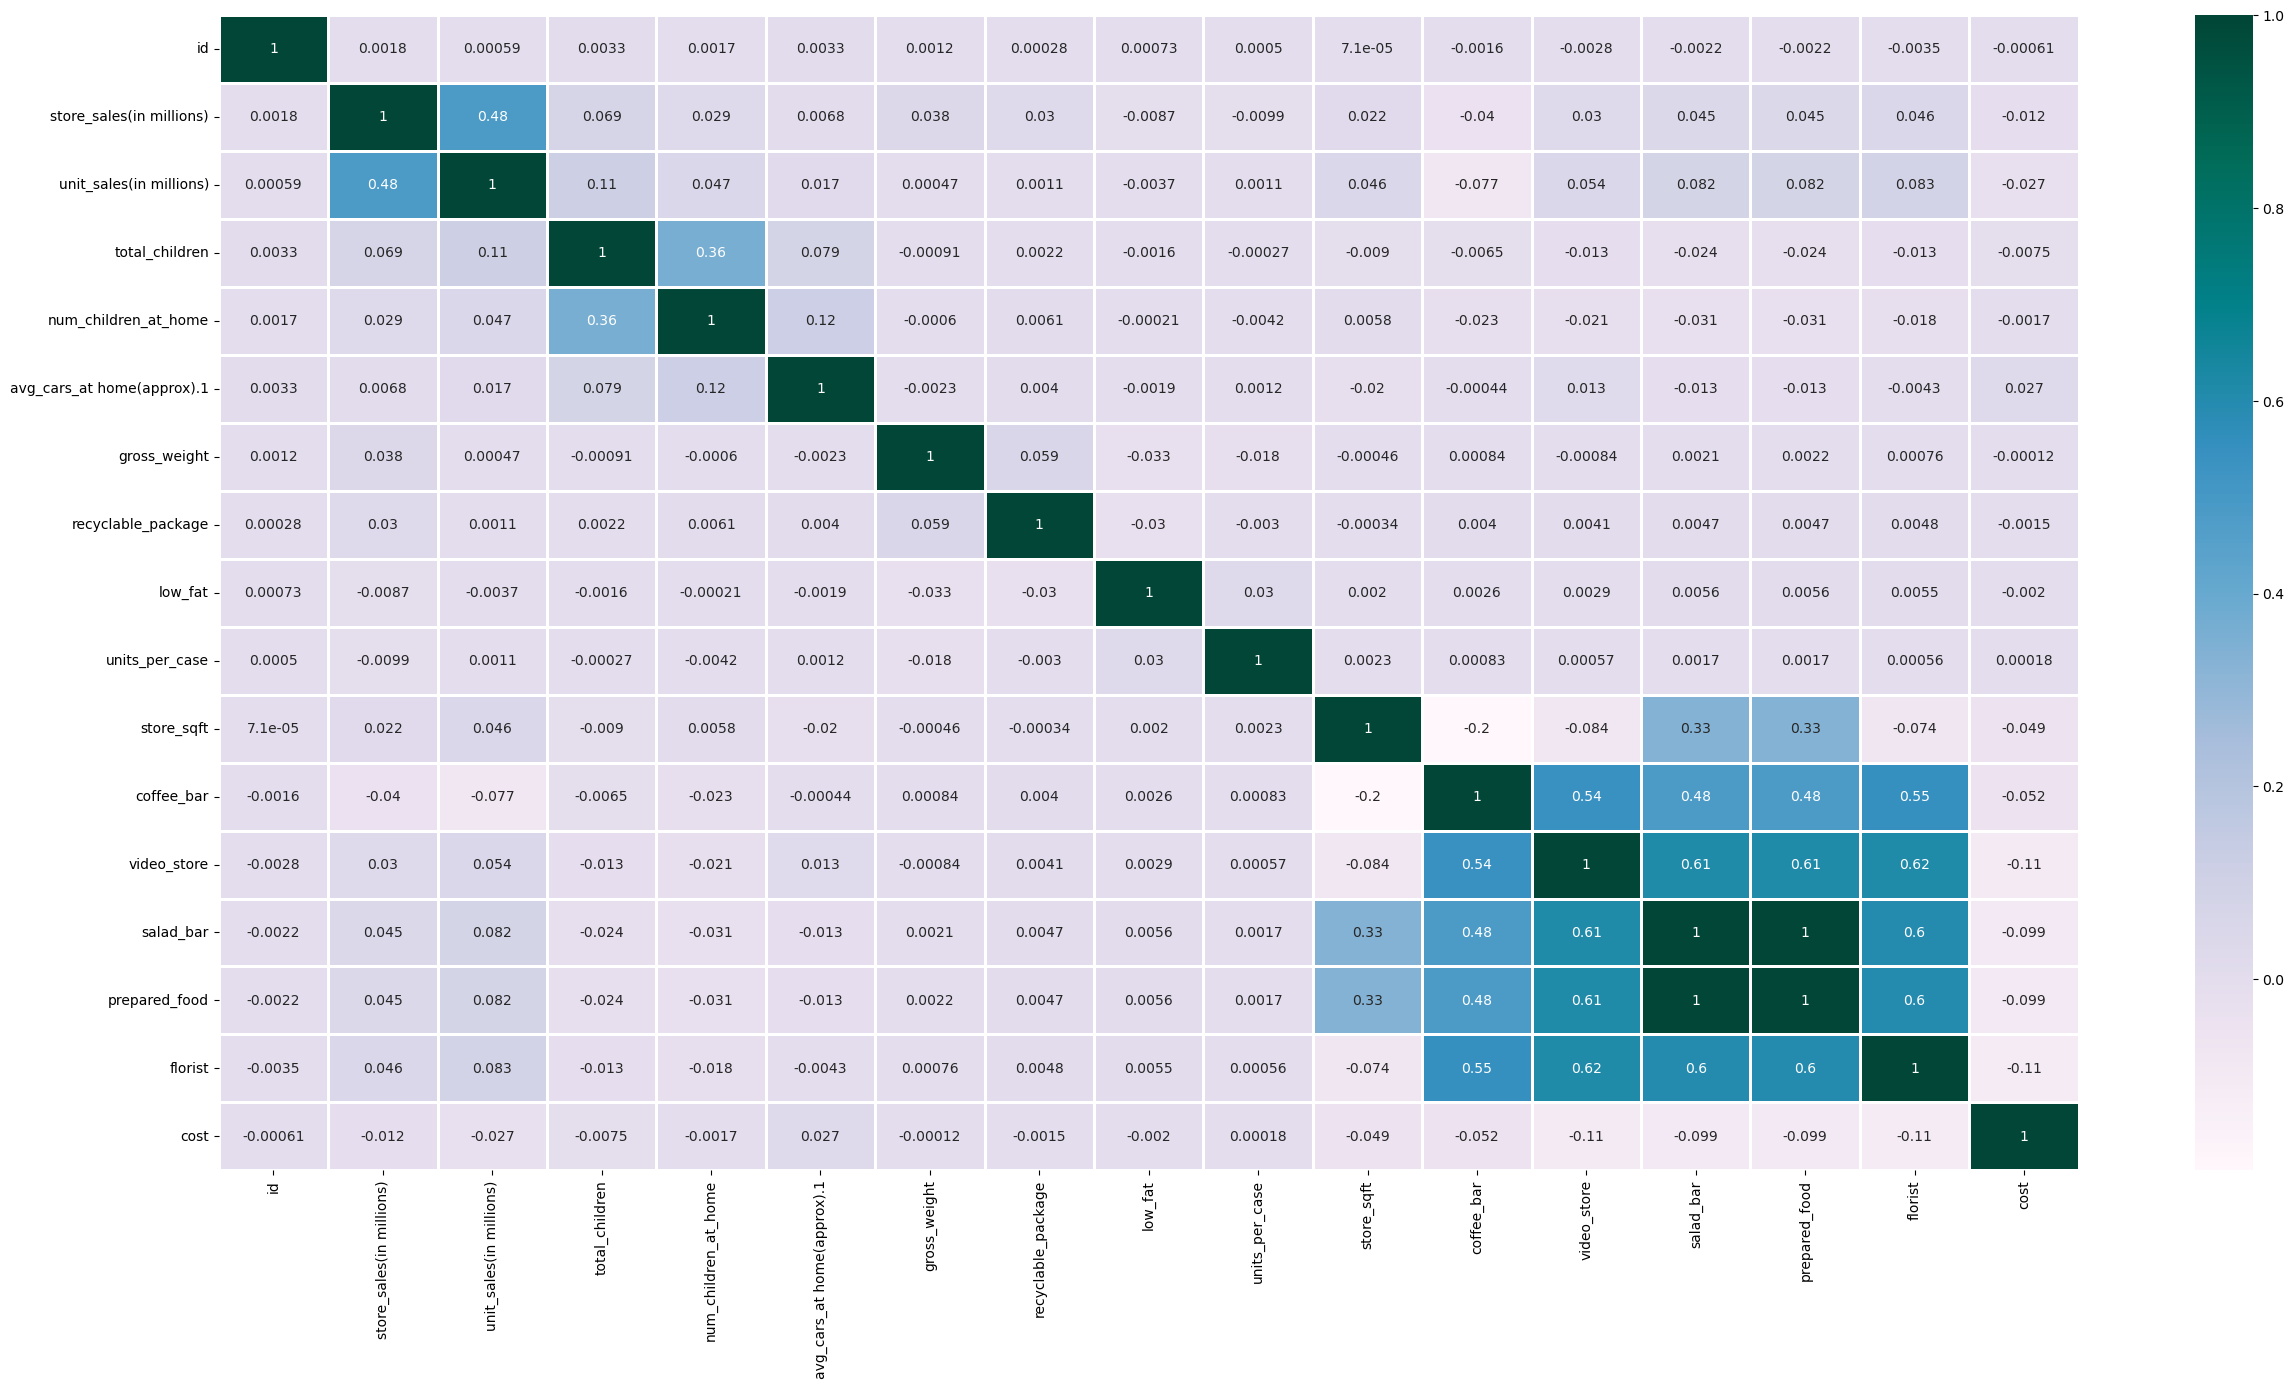

In [6]:
plt.figure(figsize=(30, 15))
sns.heatmap(data.corr(), annot=True, linewidth=2, cmap='PuBuGn')

**Можно отметить:**

* **целевое значение Cost не имеет сильной корреляции с каким-либо из признаков;**
* **имеется полная корреляция признаков salad_bar и prepared_food. Значит, можно откинуть один из них (в данном случае откнем prepared_food).**

# **3.1. Бинарные признаки**

Сравним количество значений бинарных признаков.

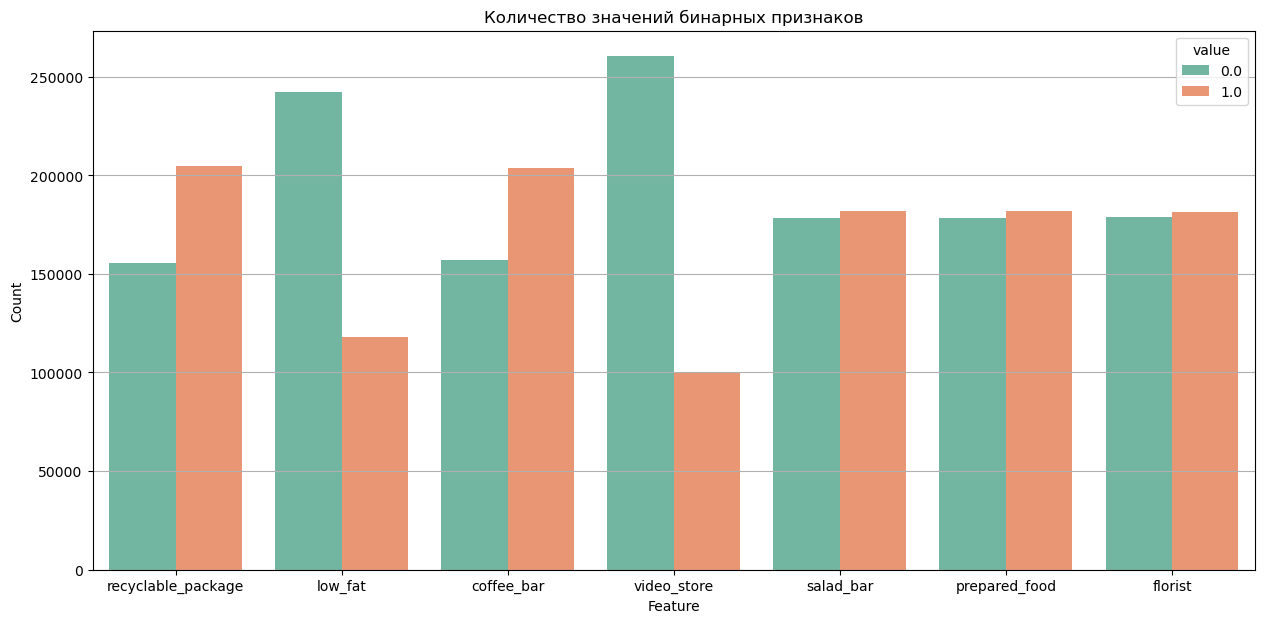

In [8]:
boolean_cols = ['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']

boolean_features_df = pd.melt(data, id_vars=['id'], value_vars=boolean_cols)

plt.figure(figsize=(15, 7))
cmap = sns.color_palette('Set2')
ax = sns.countplot(data=boolean_features_df, x='variable', hue='value', palette=cmap)
ax.yaxis.grid()
ax.set_ylabel('Count')
ax.set_xlabel('Feature')
ax.set_title('Количество значений бинарных признаков')

plt.show()

**Можно заметить, что распределение значений признака florist распределением значений признаков salad_bar и prepared_food, однако эти признаки не имеют идеальной корреляции.**

# **3.2. Численные признаки (действительные числа)**

Посмотрим на распределение численных признаков, принимающих действительные значения. Построим для них violin и box диаграммы.

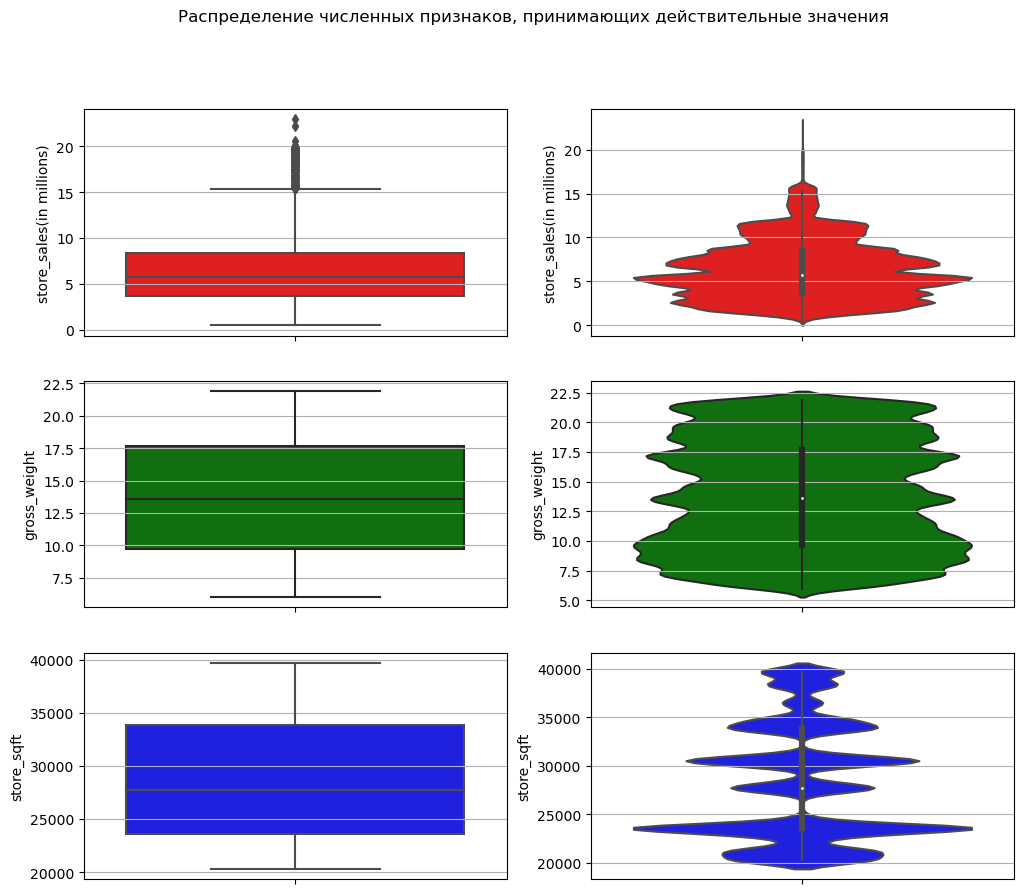

In [10]:
continuous_cols = ['store_sales(in millions)', 'gross_weight', 'store_sqft']
continuous_features_df = data[continuous_cols]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

col = 0
colors = ['red', 'green', 'blue']

for i, column in enumerate(continuous_cols):
    ax = sns.boxplot(data=continuous_features_df, y=column, ax=axes[i, col], color=colors[i])
    ax.yaxis.grid()
    ax.set_ylabel(column)
    
    ax = sns.violinplot(data=continuous_features_df, y=column, ax=axes[i, col + 1], color=colors[i])
    ax.yaxis.grid()
    ax.set_ylabel(column)
    
fig.suptitle('Распределение численных признаков, принимающих действительные значения')
plt.show()

**Можем заметить, что каких-либо выбросов в данных в целом не наблюдается.**

# **3.3. Порядковые признаки**

Посмотрим на распределение порядковых признаков

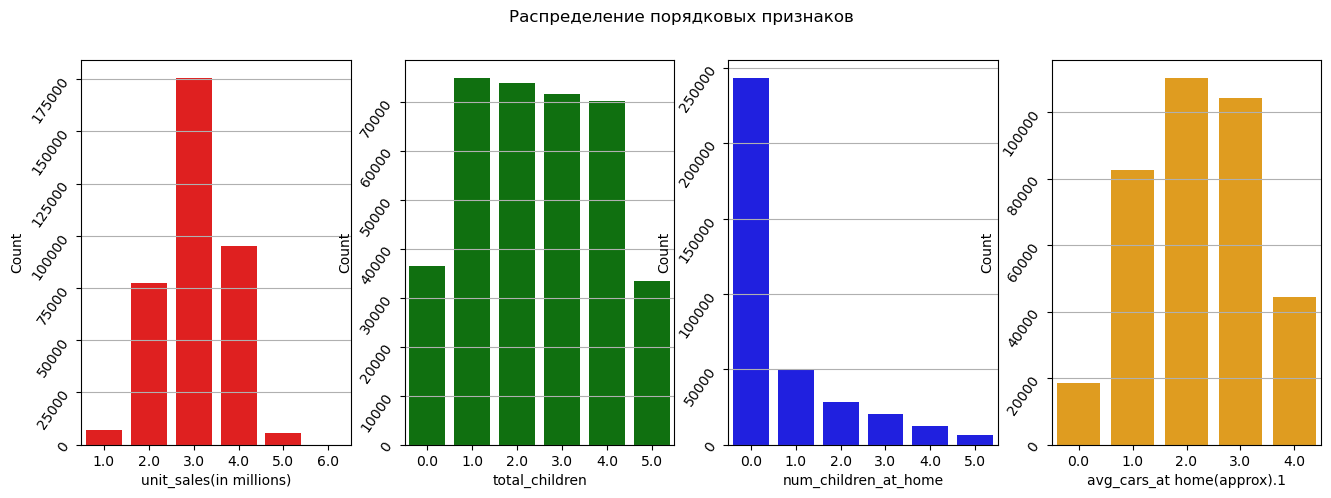

In [11]:
ordinal_cols = ['unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'units_per_case']
ordinal_features_df = data[ordinal_cols]
colors = ['red', 'green', 'blue', 'orange', 'purple']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
for i, col in enumerate(ordinal_cols[:-1]):
    ax = sns.countplot(data=ordinal_features_df, x=col, ax=axes[i], color=colors[i])
    ax.yaxis.grid()
    ax.set_ylabel('Count')
    ax.set_xlabel(col)
    ax.tick_params(axis='y', rotation=55)

fig.suptitle('Распределение порядковых признаков')
plt.show()

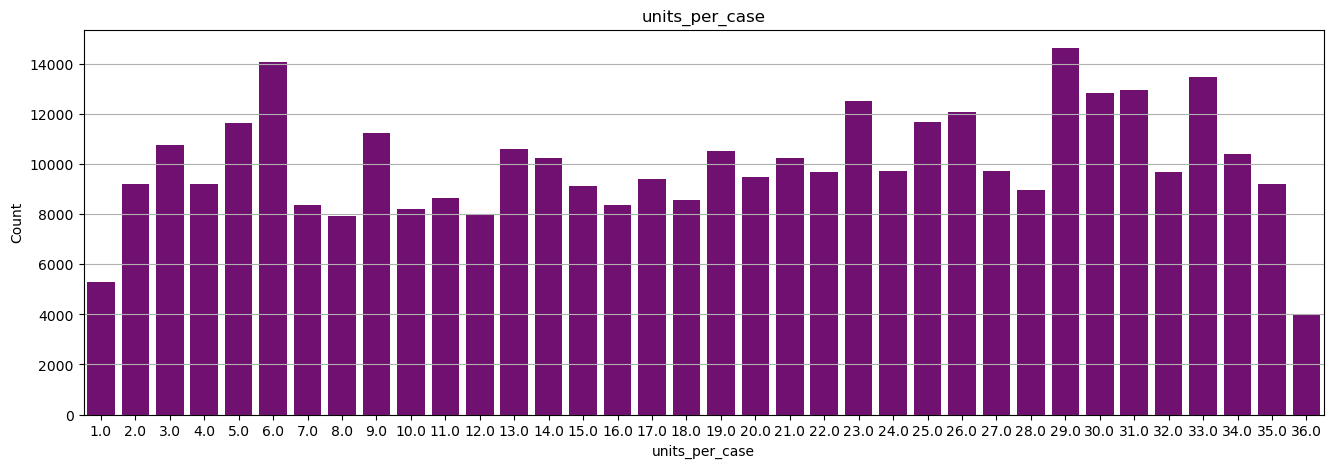

In [10]:
plt.figure(figsize=(16, 5))
ax = sns.countplot(data=ordinal_features_df, x=ordinal_cols[-1], color=colors[-1])
ax.yaxis.grid()
ax.set_ylabel('Count')
ax.set_xlabel(ordinal_cols[-1])
ax.set_title(ordinal_cols[-1])
plt.show()

**Добавим дополнительные признаки:**

* **children_ratio: отношение total_childer к num_children_at_home**
* **store_sqft_florist: произведение среднего значения store_sqft и florist**
* **store_sqft_quad: квадрат разности store_sqft и среднего значения store_sqft**

**С помощью метода scikit-learn mutual_info_regression оценим важность получившихся признаков. После этого снова проверим корреляцию между признаками. Заметим, что признаки store_sqft_florist и**
**florist имеют очень сильную корреляцию, однако, согласно нашей оценке, store_sqft_florist имеет большую важность. Откинем признак florist.**

In [18]:
X_train = data.drop(columns=['id', 'cost'])
X_train = feature_engeenering(X_train)
Y_train = data['cost']

info_scores = mutual_info_regression(X_train, Y_train, random_state=42)
print(pd.Series(info_scores, index=X_train.columns.tolist()).round(4))

cols_to_drop = ['gross_weight','recyclable_package','low_fat','units_per_case','store_sales(in millions)', 'store_sqft', 'prepared_food', 'florist']
X_train = drop_useless_cols(X_train, cols_to_drop)

store_sales(in millions)      0.0282
unit_sales(in millions)       0.0809
total_children                0.1176
num_children_at_home          0.0830
avg_cars_at home(approx).1    0.0873
gross_weight                  0.0000
recyclable_package            0.0019
low_fat                       0.0023
units_per_case                0.0004
store_sqft                    2.7028
coffee_bar                    0.5963
video_store                   0.5176
salad_bar                     0.6103
prepared_food                 0.6085
florist                       0.6305
children_ratio                0.1193
store_sqft_florist            1.6525
store_sqft_quad               2.7035
dtype: float64


<Axes: >

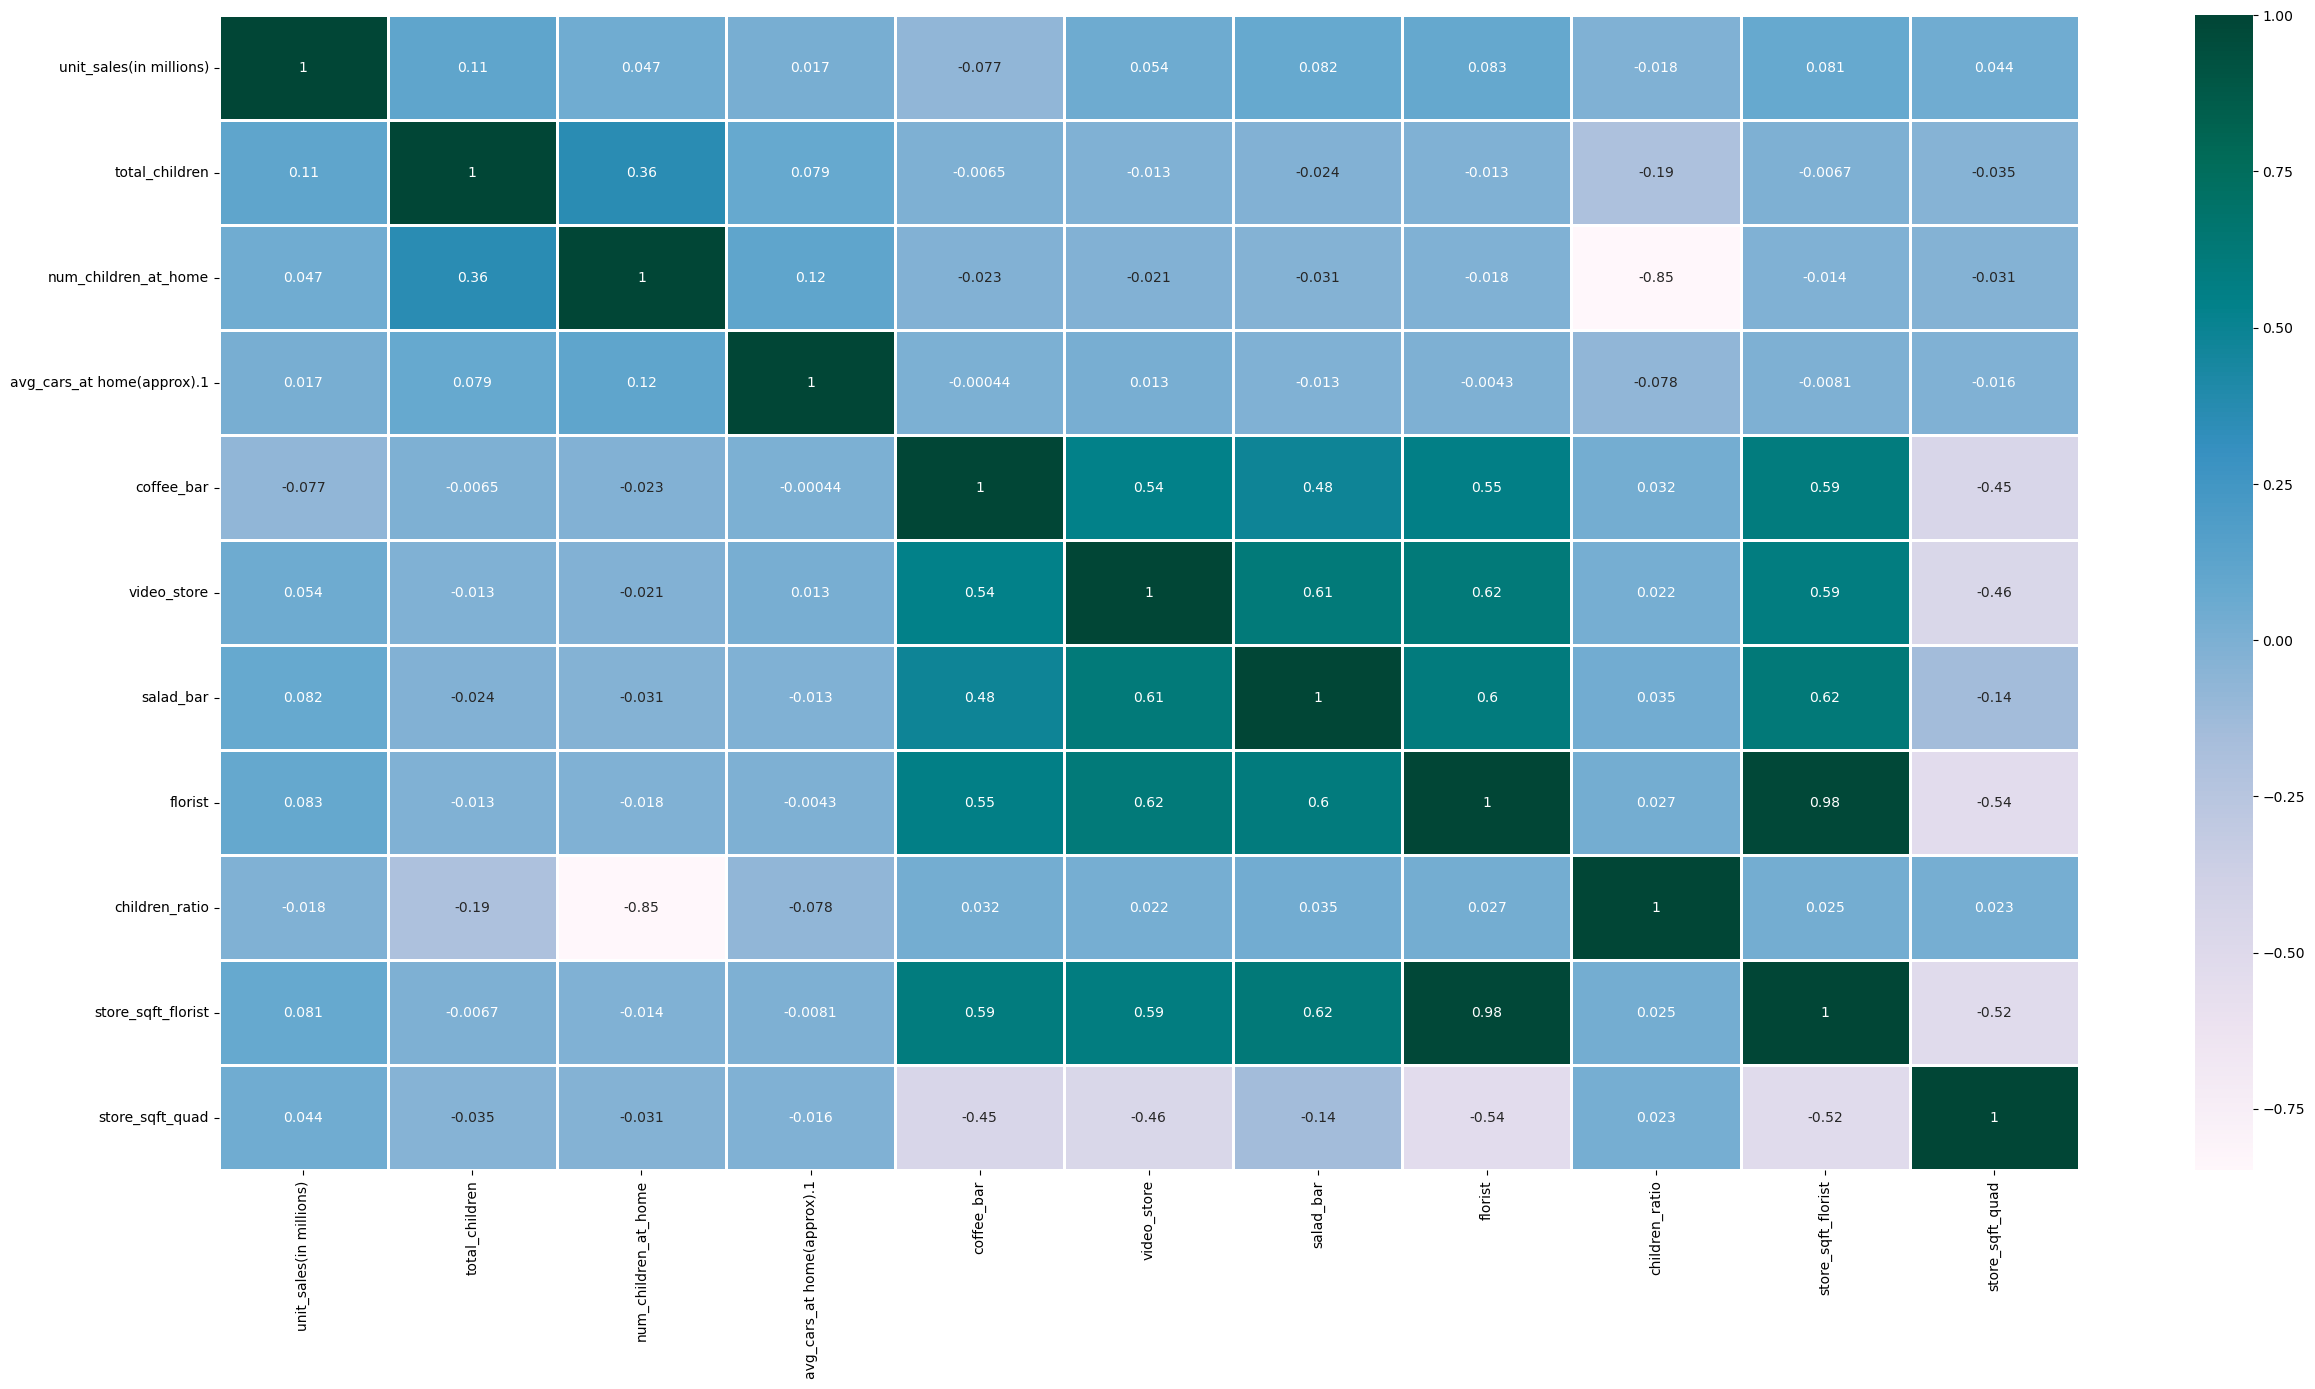

In [19]:
plt.figure(figsize=(30, 15))
sns.heatmap(X_train.corr(), annot=True, linewidth=2, cmap='PuBuGn')

**Разделим данные на тренировочную и валидационную выборки. Также воспользуемся StandardScaler для нормирования данных.**
**Для обучения и последующих предсказаний будем использовать модель XGBRegressor. Поскольку XGBRegressor не поддерживает функцию ошибки RMSLE, которая используется в соревновании,**
**будем обучать модель предсказывать не cost в том виде, в котором он представлен в исходных данных, а log(cost + 1). Предсказания такой модели для вычисления метрики будем преобразовывать**
**следующим образом: exp(predicted_cost - 1)**

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, random_state=42)

feature_preprocessor = StandardScaler()
X_train = feature_preprocessor.fit_transform(X_train)
X_val = feature_preprocessor.transform(X_val)

Y_train_log = Y_train.apply(lambda x: np.log(x + 1))
Y_val_log = Y_val.apply(lambda x: np.log(x + 1))

**Параметры модели были оптимизированы с помощью библиотеки optuna.**

In [ ]:
regressor = XGBRegressor(
    objective='reg:squaredlogerror',
    random_state=42,
    colsample_bytree=1.0,
    gamma=1.999973e-07,
    learning_rate=0.053006,
    max_depth=12,
    n_estimators=1000,
    reg_alpha=6.075492e-06,
    reg_lambda=1.000000e+02,
    subsample=1.0
)

regressor.fit(X_train, Y_train_log)

preds = np.exp(regressor.predict(X_val)) - 1

print(mean_squared_log_error(Y_val, preds, squared=False))

# **Сделаем submission**

**Сначала подготовим тестовые данные, проделав те же операции, что и на обучающей выборке. Затем сделаем предсказание и запишем их в файл submission.csv**

In [16]:

X_train = data.drop(columns=['id', 'cost'])
Y_train = data['cost'].apply(lambda x: np.log(x + 1))
cols_to_drop = ['gross_weight','recyclable_package','low_fat','units_per_case','store_sales(in millions)', 'store_sqft']

feature_preprocessor = StandardScaler()
X_train = feature_engeenering(X_train)
X_train = drop_useless_cols(X_train, cols_to_drop)
X_train = feature_preprocessor.fit_transform(X_train)

X_test = feature_engeenering(X_test)
X_test = drop_useless_cols(X_test, cols_to_drop)
X_test = feature_preprocessor.transform(X_test)

In [25]:
submission['cost'] = np.exp(regressor.predict(X_test)) - 1

submission.to_csv('submission.csv')

**Итоговый результат**

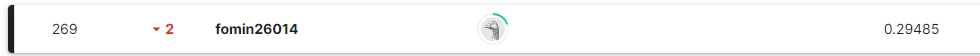
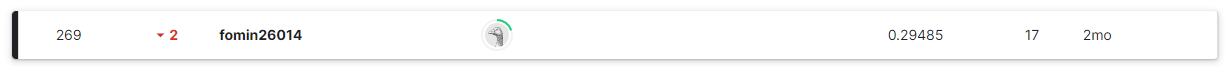